# Anomaly Detection
### aka. How to Convince Your Boss that you need Machine Learning

---

Michal Grochmal <michal.grochmal@city.ac.uk>



<div style="text-align:right;font-size:0.7em;">crown-scaled.svg</div>

## ToC

- General Intro
  + Supervised vs Unsupervised - Regression-like
  + Three things: Novelty Detection vs Outlier Detection, Explainability and Feature Extraction, Time Series
- Explain the data
  + Webserver Logs
  + When we are not after time series
- Statistics of the Time Series
  + ARIMA
  + Is ARIMA worth it?
  + Other methods - including multidimensional ARIMA
- ML-like Stuff
  + Dimensionality
  + Description on every technique
  + All data with SVM and with Desity Isolation

Planned schedule:

- 5mins - Anomaly Pictures
- 5mins - Data Explanation and Trivial Stats, ARIMA vs mean plus std
- 5mins -
- 10mins -


- 5mins - Outline of where anomaly detection can be used
- 5mins - Quick summary of techniques
- 10mins - Example with a Gaussian process
- 5mins - Real world story where AD got implemented in a non-ML environment

Where's the anomaly?



<div style="text-align:right;font-size:0.7em;">fly-anomaly.svg</div>

But if we make continuous steps, the spider is not an anomaly.



<div style="text-align:right;font-size:0.7em;">fly-norm.svg</div>

Or even, if both the spider and the fly are common, neither is an anomaly.



<div style="text-align:right;font-size:0.7em;">fly-spider-norm.svg</div>

We can bend this further.
If we have the fly "evolve" into a spider as before,
then a complete fly in the wrong position is an anomaly too.



<div style="text-align:right;font-size:0.7em;">fly-spider-anomaly.svg</div>

This leads us to one way of understanding anomalies: as a time-series.

In [1]:
import json
import numpy as np
import pandas as pd
from matplotlib import patheffects, pyplot as plt
%matplotlib inline
plt.style.use('myxkcd')



<div style="text-align:right;font-size:0.7em;">the-data.svg</div>

## Data: Webserver Logs

We will use

In [2]:
with open('access.log', encoding='latin-1') as f:
    df = pd.DataFrame(json.loads(l) for l in f)
with open('access.labels') as f:
    df['label'] = pd.Series(int(l) for l in f)
df.head()

,bytes_sent,content_length,content_type,cookie_csrftoken,cookie_sessionid,cookie_userid,geoip_city,geoip_country_code3,geoip_country_name,geoip_latitude,...,ssl_cipher,ssl_curves,ssl_protocol,ssl_session_reused,status,time_iso8601,upstream_cache_status,upstream_response_time,upstream_status,label
0,486,,,,,,,USA,United States,13.7500,...,ECDHE-RSA-AES128-GCM-SHA256,0x001d:prime256v1:secp384r1,TLSv1.2,.,301,2018-05-11T03:33:26+00:00,,,,1
1,2999,,,,,,Saint Petersburg,RUS,Russian Federation,59.8944,...,,,,,200,2018-05-11T03:34:33+00:00,MISS,0.000,200,1
2,481,,,,,,,USA,United States,13.7500,...,ECDHE-RSA-AES128-GCM-SHA256,0x001d:prime256v1:secp384r1,TLSv1.2,.,301,2018-05-11T03:51:23+00:00,,,,1
3,449,,,,,,Edison,USA,United States,40.4981,...,,,,,301,2018-05-11T04:02:52+00:00,,,,1
4,792,,,,,,Saint Petersburg,RUS,Russian Federation,59.8944,...,,,,,200,2018-05-11T05:09:04+00:00,,,,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 39 columns):
bytes_sent                10789 non-null int64
content_length            10789 non-null object
content_type              10789 non-null object
cookie_csrftoken          10789 non-null object
cookie_sessionid          10789 non-null object
cookie_userid             10789 non-null object
geoip_city                10789 non-null object
geoip_country_code3       10789 non-null object
geoip_country_name        10789 non-null object
geoip_latitude            10789 non-null object
geoip_longitude           10789 non-null object
geoip_region_name         10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null object
http2                     10789 non-null object
http_referer              10789 non-null object
http_user_agent           10789 non-null object
http_x_csrf_token         10789 non-null object
http_x_forwarded_for      10

In [4]:
for i in df.columns:
    print(i, len(df[i].unique()))

bytes_sent 379
content_length 21
content_type 16
cookie_csrftoken 1
cookie_sessionid 1
cookie_userid 2
geoip_city 609
geoip_country_code3 84
geoip_country_name 84
geoip_latitude 772
geoip_longitude 777
geoip_region_name 373
gzip_ratio 37
host 42
http2 2
http_referer 141
http_user_agent 282
http_x_csrf_token 1
http_x_forwarded_for 7
remote_addr 2444
remote_port 6806
request 472
request_id 10789
request_length 479
request_method 6
request_time 67
request_uri 384
scheme 2
server_protocol 4
ssl_cipher 8
ssl_curves 22
ssl_protocol 4
ssl_session_reused 3
status 12
time_iso8601 7630
upstream_cache_status 4
upstream_response_time 31
upstream_status 6
label 2


In [5]:
df = df.drop([
    'content_length',         # only present in POST, duplicate of request_method: POST
    'cookie_csrftoken',       # no variance
    'cookie_sessionid',       # no variance
    'cookie_userid',          # low variance
    'geoip_city',             # use geoip_country_name
    'geoip_country_code3',    # use geoip_country_name
    'geoip_latitude',         # use geoip_country_name
    'geoip_latitude',         # use geoip_country_name
    'geoip_longitude',        # use geoip_country_name
    'geoip_region_name',      # use geoip_country_name
    'http_x_csrf_token',      # no variance
    'remote_addr',            # too much variance
    'remote_port',            # this is actually random
    'request_id',             # unique ID
    'ssl_curves',             # use ssl_cipher
    'ssl_protocol',           # use ssl_cipher,
    'upstream_cache_status',  # use upstream_response_time
    'upstream_status',        # use upstream_response_time
], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 22 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null object
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null object
http2                     10789 non-null object
http_referer              10789 non-null object
http_user_agent           10789 non-null object
http_x_forwarded_for      10789 non-null object
request                   10789 non-null object
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null object
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10789 non-null object
status                    10

In [6]:
request_functions = {min: 0xff, max: 0}
column = 'request'
for f in request_functions:
    df[column + '_' + f.__name__] = pd.Series(
        f([ord(c) for c in row] + [request_functions[f]]) for row in df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 24 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null object
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null object
http2                     10789 non-null object
http_referer              10789 non-null object
http_user_agent           10789 non-null object
http_x_forwarded_for      10789 non-null object
request                   10789 non-null object
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null object
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10789 non-null object
status                    10

In [7]:
len_columns = [
    'content_type',
    'host',
    'http_referer',
    'http_user_agent',
    'http_x_forwarded_for',
    'request',  # here again, we may as well take the length too
    'request_uri',
]
for c in len_columns:
    df[c] = df[c].str.len()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 24 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null int64
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null int64
http2                     10789 non-null object
http_referer              10789 non-null int64
http_user_agent           10789 non-null int64
http_x_forwarded_for      10789 non-null int64
request                   10789 non-null int64
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null int64
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10789 non-null object
status                    10789 non

In [8]:
numbers = [
    'gzip_ratio',
    'upstream_response_time',
]
for c in numbers:
    df.loc[df[c] == '', c] = 0  # prevent NaNs
    df[c] = pd.to_numeric(df[c])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 24 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null int64
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null float64
host                      10789 non-null int64
http2                     10789 non-null object
http_referer              10789 non-null int64
http_user_agent           10789 non-null int64
http_x_forwarded_for      10789 non-null int64
request                   10789 non-null int64
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null int64
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10789 non-null object
status                    10789 no

In [9]:
dummies = [
    'geoip_country_name',
    'http2',
    'request_method',
    'scheme',
    'server_protocol',
    'ssl_cipher',
    'ssl_session_reused',
    'status',
]
df = pd.get_dummies(df, columns=dummies)
df.columns

Index(['bytes_sent', 'content_type', 'gzip_ratio', 'host', 'http_referer',
       'http_user_agent', 'http_x_forwarded_for', 'request', 'request_length',
       'request_time',
       ...
       'status_302', 'status_304', 'status_400', 'status_403', 'status_404',
       'status_408', 'status_418', 'status_429', 'status_500', 'status_502'],
      dtype='object', length=137)

In [11]:
df.head()

,bytes_sent,content_type,gzip_ratio,host,http_referer,http_user_agent,http_x_forwarded_for,request,request_length,request_time,...,status_304,status_400,status_403,status_404,status_408,status_418,status_429,status_500,status_502,time_of_day
0,486,0,0.0,12,0,71,0,19,272,0.0,...,0,0,0,0,0,0,0,0,0,3
1,2999,0,2.6,16,0,64,0,52,258,0.0,...,0,0,0,0,0,0,0,0,0,3
2,481,0,0.0,12,0,71,0,14,267,0.0,...,0,0,0,0,0,0,0,0,0,3
3,449,0,0.0,1,0,59,0,14,104,0.0,...,0,0,0,0,0,0,0,0,0,4
4,792,0,0.0,16,0,64,0,24,199,0.0,...,0,0,0,0,0,0,0,0,0,5


In [12]:
df[['status_200', 'status_301', 'status_302', 'status_304',
    'status_400', 'status_403', 'status_404', 'status_500',
    'gzip_ratio', 'time_of_day', 'time_iso8601', 'label']].head(10)

,status_200,status_301,status_302,status_304,status_400,status_403,status_404,status_500,gzip_ratio,time_of_day,time_iso8601,label
0,0,1,0,0,0,0,0,0,0.00,3,2018-05-11 03:33:26,1
1,1,0,0,0,0,0,0,0,2.60,3,2018-05-11 03:34:33,1
2,0,1,0,0,0,0,0,0,0.00,3,2018-05-11 03:51:23,1
3,0,1,0,0,0,0,0,0,0.00,4,2018-05-11 04:02:52,1
4,1,0,0,0,0,0,0,0,0.00,5,2018-05-11 05:09:04,1
5,1,0,0,0,0,0,0,0,2.52,5,2018-05-11 05:09:08,1
6,0,0,0,0,1,0,0,0,0.00,5,2018-05-11 05:20:51,-1
7,1,0,0,0,0,0,0,0,3.43,5,2018-05-11 05:41:14,1
8,1,0,0,0,0,0,0,0,1.64,5,2018-05-11 05:51:06,1
9,1,0,0,0,0,0,0,0,2.08,5,2018-05-11 05:51:08,1


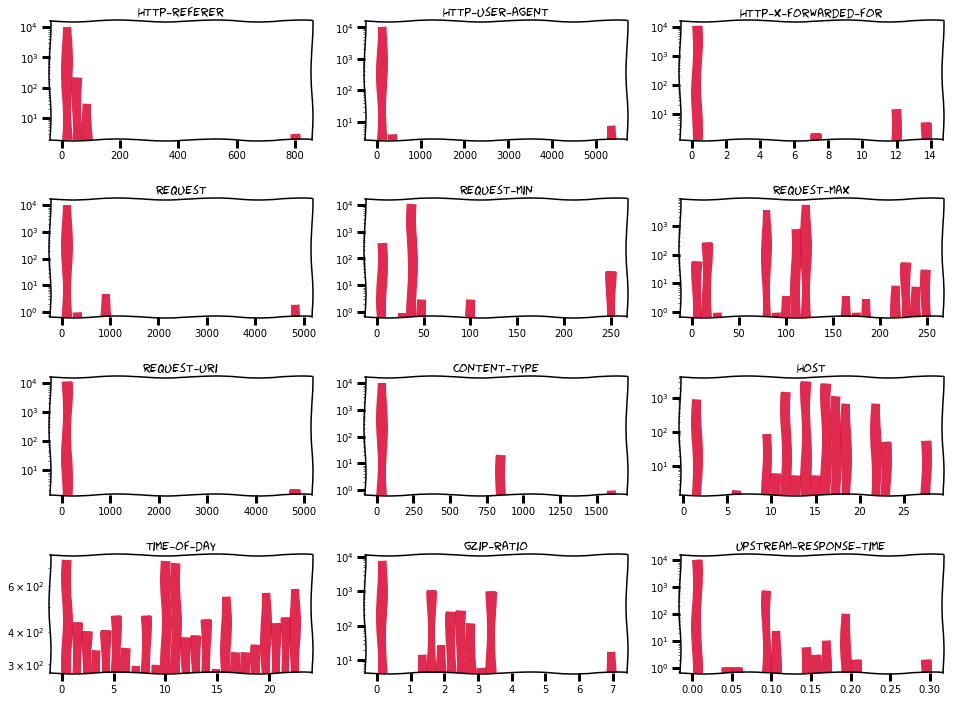

In [13]:
fig, axi = plt.subplots(4, 3, figsize=(16, 12))
columns = [
    'http_referer',
    'http_user_agent',
    'http_x_forwarded_for',
    'request',
    'request_min',
    'request_max',
    'request_uri',
    'content_type',
    'host',
    'time_of_day',
    'gzip_ratio',
    'upstream_response_time',
]
for i in range(len(columns)):
    ax = axi.flat[i]
    ax.hist(df[columns[i]], log=True, bins=24,
            histtype='bar', facecolor='crimson', alpha=0.9)
    ax.set_title(columns[i], fontname='Humor Sans')
fig.subplots_adjust(wspace=0.2, hspace=0.5)



<div style="text-align:right;font-size:0.7em;">time-series.svg</div>

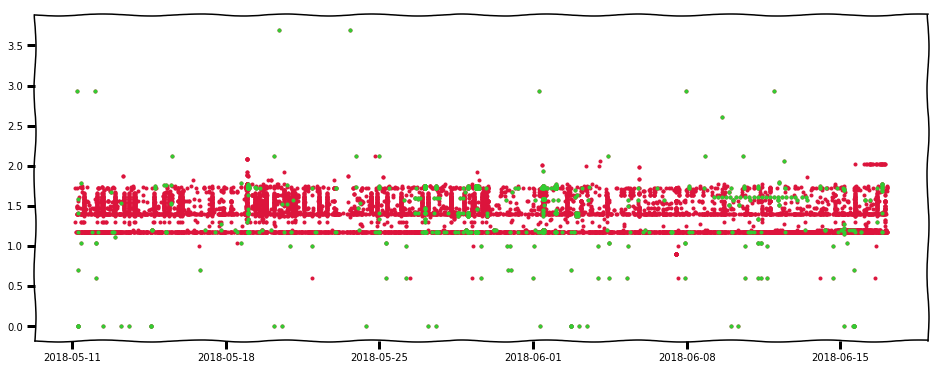

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
ano = df.label == -1
ax.plot(df.time_iso8601, np.log10(df.request + 1), '.', color='crimson')
ax.plot(df.time_iso8601[ano], np.log10(df.request[ano] + 1), '.', color='limegreen');

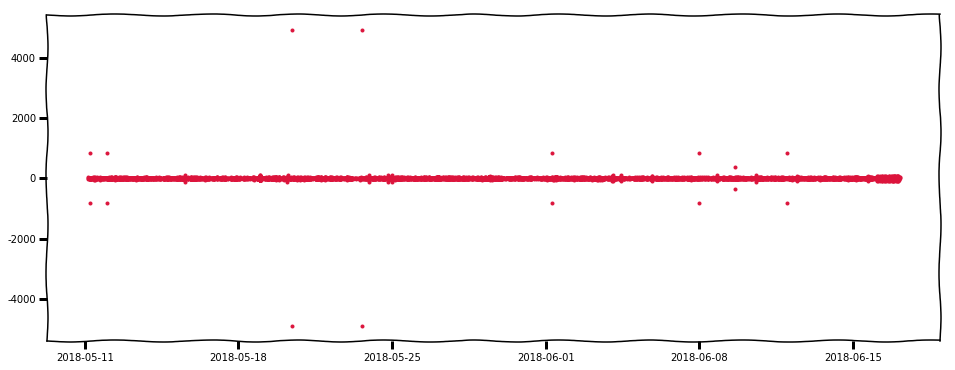

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))
diff = df.request[:-1].values - df.request[1:].values
ax.plot(df.time_iso8601[1:], diff, '.', color='crimson');

In [24]:
import statsmodels.api as sm

y = df.request
ar, diffi, ma = 3, 1, 0
sarimax = sm.tsa.statespace.SARIMAX(y, order=(ar, diffi, ma))
results = sarimax.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                request   No. Observations:                10789
Model:               SARIMAX(3, 1, 0)   Log Likelihood              -62409.417
Date:                Sat, 01 Sep 2018   AIC                         124826.834
Time:                        02:17:49   BIC                         124855.978
Sample:                             0   HQIC                        124836.662
                              - 10789                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7461      0.001  -1208.498      0.000      -0.747      -0.745
ar.L2         -0.4963      0.001   -687.268      0.000      -0.498      -0.495
ar.L3         -0.2489      0.001   -396.117      0.000      -0.250      -0.248
sigma2      6201.0363      2.237   2772.415      0.000    6196.652    6205.420
===================================================================================
Ljung-Box (Q):                      815.57   Jarque-Bera (JB):        3653070587.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            42.60
Prob(H) (two-sided):                  0.00   Kurtosis:                      2852.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

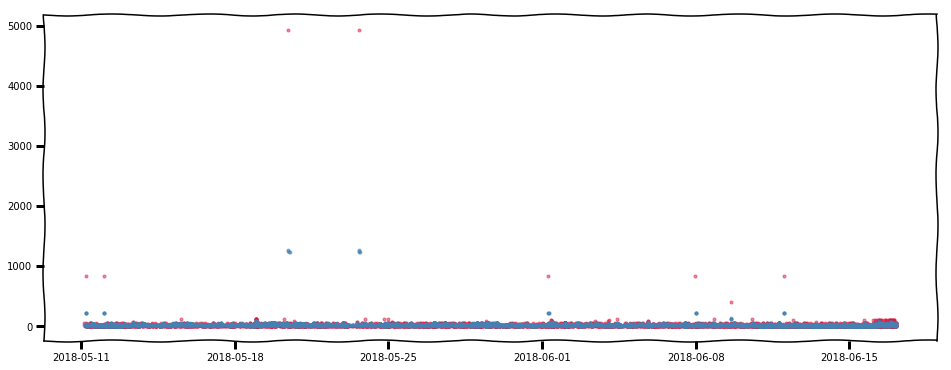

In [25]:
pred_y = results.predict(start=diffi, end=len(y)-diffi)
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df.time_iso8601[diffi:], df.request[diffi:], '.', color='crimson', alpha=0.5)
ax.plot(df.time_iso8601[diffi:], pred_y, '.', color='steelblue', alpha=0.5);

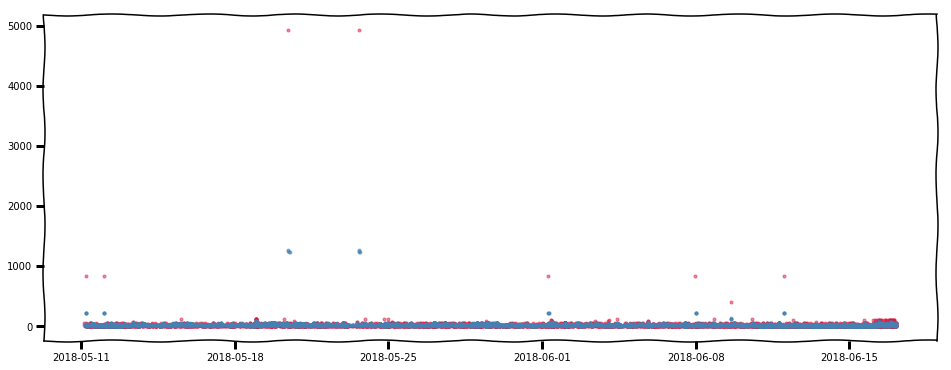

In [26]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df.time_iso8601[diffi:], df.request[diffi:], '.', color='crimson', alpha=0.5)
ax.plot(df.time_iso8601[diffi:], pred_y, '.', color='steelblue', alpha=0.5);

In [27]:
y = pd.Series(df.request[df.request < 200].values)
ar, diffi, ma = 3, 1, 0
sarimax = sm.tsa.statespace.SARIMAX(y, order=(ar, diffi, ma))
results = sarimax.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10781
Model:               SARIMAX(3, 1, 0)   Log Likelihood              -43424.135
Date:                Sat, 01 Sep 2018   AIC                          86856.271
Time:                        02:17:58   BIC                          86885.413
Sample:                             0   HQIC                         86866.098
                              - 10781                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6142      0.006   -109.616      0.000      -0.625      -0.603
ar.L2         -0.3923      0.007    -52.335      0.000      -0.407      -0.378
ar.L3         -0.2313      0.006    -35.626      0.000      -0.244      -0.219
sigma2       184.5791      1.149    160.633      0.000     182.327     186.831
===================================================================================
Ljung-Box (Q):                      696.98   Jarque-Bera (JB):             29672.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

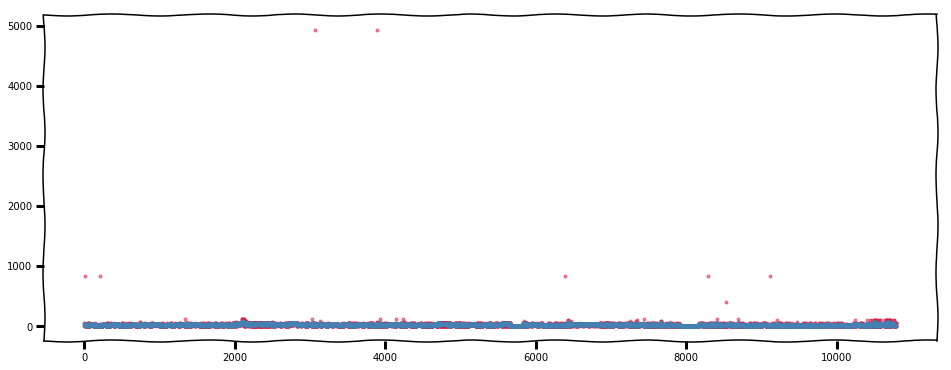

In [28]:
pred_y = results.predict(start=diffi, end=len(y)-diffi)
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(range(len(df.request)-diffi), df.request[diffi:], '.', color='crimson', alpha=0.5)
ax.plot(range(len(y)-diffi), pred_y, '.', color='steelblue', alpha=0.5);



<div style="text-align:right;font-size:0.7em;">machine-learning.svg</div>

In [10]:
column = 'time_iso8601'
df[column] = pd.to_datetime(df[column])
df['time_of_day'] = df[column].dt.hour
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Columns: 138 entries, bytes_sent to time_of_day
dtypes: datetime64[ns](1), float64(3), int64(13), uint8(121)
memory usage: 2.6 MB


In [29]:
from sklearn.preprocessing import StandardScaler

scaled_columns = [
    'bytes_sent',
    'content_type',
    'gzip_ratio',
    'host',
    'http_referer',
    'http_user_agent',
    'http_x_forwarded_for',
    'request',
    'request_length',
    'request_time',
    'request_uri',
    'upstream_response_time',
    'request_min',
    'request_max',
    'time_of_day',
]
scaler = StandardScaler(copy=True)
mldf = pd.DataFrame(scaler.fit_transform(df[scaled_columns]), columns=scaled_columns)
cat_cols = [x for x in df.columns if x not in scaled_columns + ['time_iso8601', 'label']]
mldf[cat_cols] = df[cat_cols]
mldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Columns: 136 entries, bytes_sent to status_502
dtypes: float64(15), uint8(121)
memory usage: 2.5 MB


In [38]:
X, y = mldf.values, df.label

incidents = np.sum(df.label == -1)
incident_factor = incidents / len(mldf)
incident_factor

0.08999907313003985

In [40]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=30, contamination=incident_factor)
y_hat = lof.fit_predict(X, y)
y_hat

array([ 1,  1,  1, ...,  1, -1,  1])

In [41]:
from sklearn.metrics import f1_score

f1_score(y, y_hat)

0.9187207170503158

In [42]:
lof = LocalOutlierFactor(n_neighbors=30, contamination=0.1)
y_hat = lof.fit_predict(X)
f1_score(y, y_hat)

0.9132527652601393

In [48]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
iso = IsolationForest(n_estimators=200, contamination=incident_factor)
iso.fit(X_train, y_train)
y_hat = iso.predict(X_test)
f1_score(y_test, y_hat)

0.9944388270980788

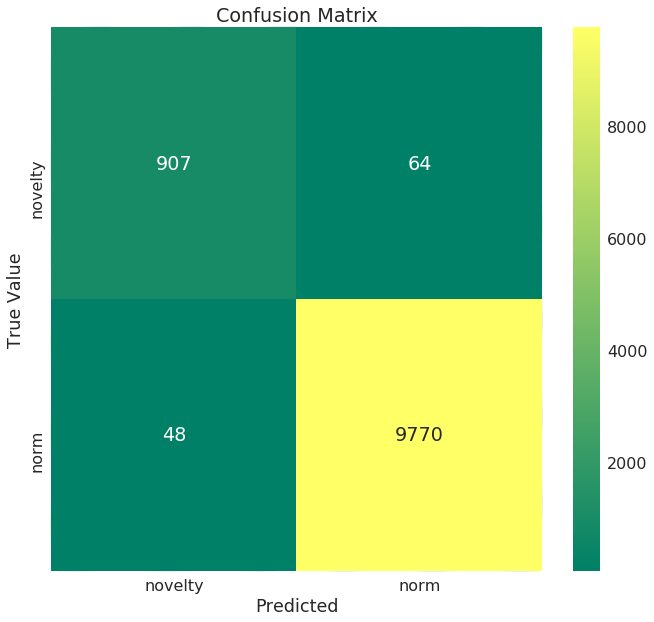

In [81]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_hat = iso.predict(X)
cm = confusion_matrix(y, y_hat)
ticks = ['novelty', 'norm']
fig, ax = plt.subplots(figsize=(11, 10))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, fmt='d', cmap='summer',
            xticklabels=ticks, yticklabels=ticks, ax=ax)
ax.set(title='Confusion Matrix', xlabel='Predicted', ylabel='True Value');

What is your session about?

This presentation comes from a recurring question I get from my students: "OK, all this machine learning stuff is great but how do you use it in real life?"

The students ask this because they come from what several of us would call old-fashioned programming jobs, where you actually program every step of what a computer does with the data. Sounds crazy, right? But that is still the reality in several companies. There are several reasons for dealing with data in that way: legacy applications, belief that hand-coded rules get 100% accuracy (yeah, right), or simply an attitude of don't fix what ain't broken - despite the fact that it is broken.

I point such students towards *Anomaly Detection* (AD). Why? Because AD is an easy technique to plug into a non-ML system. Every company has some form of data aggregation - and data scrutiny - system: be it webserver logs, forex trades, or hotel bookings data. In that scrutiny system dirty data exist, or is fed in, and there are coded rules to prevent processing of this bad data.
Instead of hand-coded rules, that is the place where ML techniques should be used, notably AD.

AD is quite easy to explain without going into mathematics, which is a good thing if you need to convince your boss. AD can be used as a substitute for hand-coded rules, as a way of tuning (hyper-)parameters for rules, or even working alongside such rules. Moreover most AD techniques can be used on both: static datasets or running time series.

We will discuss a couple of examples of AD use. AD may appear as a rather specific field to a typical programmer but that's far from true. AD is just a clever (read: slightly different) way of using well known ML techniques.
Is there anything else we should know about your proposal?

Currently, the talk is a planned presentation for one of my lectures (I teach a short course in Machine Learning at City UL). The talk is planned for 1 hour but I can (and plan) to shorten the talk to fit the time. Below, in the outline, I'm writing two plans: the current plan for a 50 minutes presentation and a squeezed 25 minutes presentation. If I can get a longer slot I can backtrack to the full talk.

The people who would mostly benefit from this talk are people who want to get into some machine learning but are struggling to get a foothold in it. Another group that may benefit slightly are people skilled in ML (e.g. sklearn and/or tensorflow) but who never worked with Anomaly Detection.